In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
current_dir = os.getcwd()
model_dir = 'model'
os.makedirs(model_dir,exist_ok=True)

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

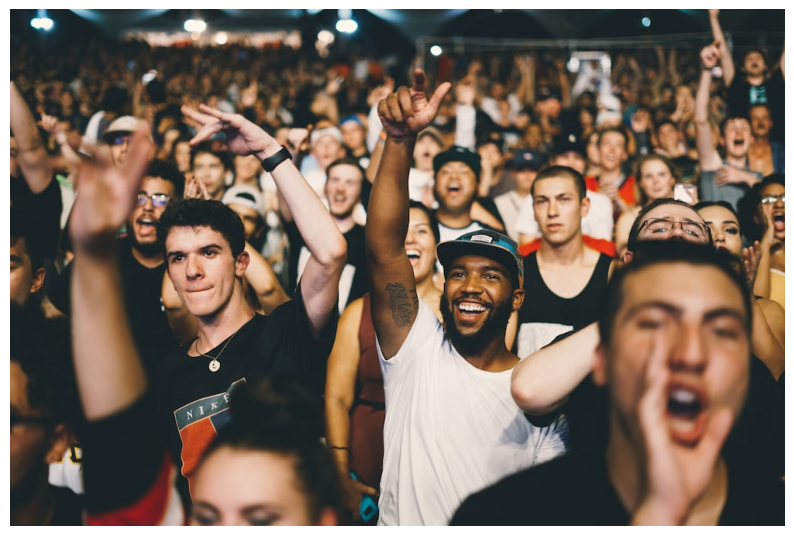

In [14]:
#image loading
import matplotlib.pyplot as plt
image = cv2.imread('people.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()



0: 448x640 5 persons, 171.8ms
Speed: 4.6ms preprocess, 171.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[653 198 783 423]


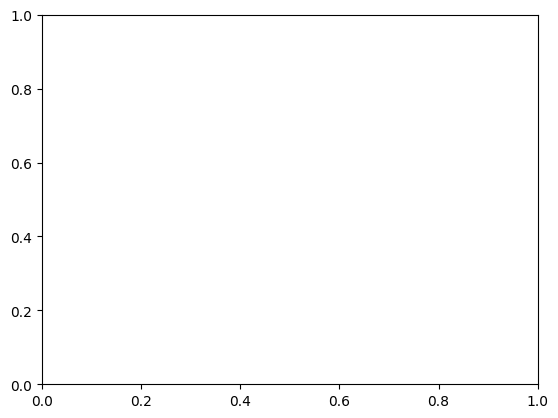

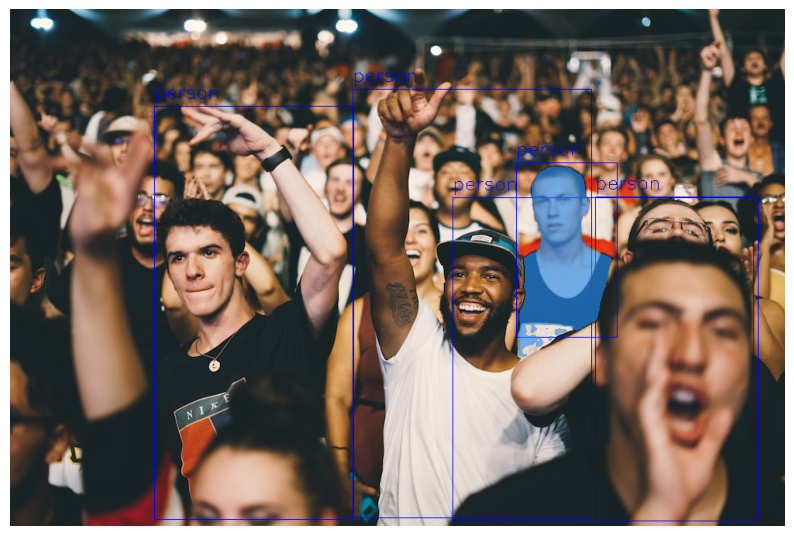

In [17]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO(model='model/yolov8n.pt')
image = cv2.imread('people.jpg')
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

object = model(image1)

for r in object:
        boxx = r.boxes
        labels = r.names
        with open('coco.txt','w+') as f:
             for label in labels.values():
                  f.write(label +'\n')
        if 'person' in labels.values():
            for box in boxx:
                with open('coco.txt','r+') as f:
                     labelname = f.read().split()[0]
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1),int(y1),int(x2),int(y2)
                cv2.rectangle(image1,(x1,y1),(x2,y2),(0,0,255),1)
                cv2.putText(image1, labelname, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1)
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)
input_box = np.array([x1, y1, x2, y2])
print(input_box)
fig, ax = plt.subplots()


masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10,10))
plt.imshow(image1)
show_mask(masks[0], plt.gca())
show_points(input_box,ax, plt.gca())
plt.axis('off')
plt.savefig('people_output.jpg')
plt.show() 

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor


In [6]:
yolo_model = YOLO(model='model/yolov8n.pt')
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = "cpu"
sam.to(device=device)
predictor = SamPredictor(sam)


In [8]:
def process_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    yolo_output = yolo_model(frame_rgb)
    for result in yolo_output:
        boxes = result.boxes
        labels = result.names

        if 'person' in labels:
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), (0, 0, 255), 1)
                with open('coco.txt', 'r+') as f:
                    labelname = f.read().split()[0]
                cv2.putText(frame_rgb, labelname, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1)

                input_box = np.array([x1, y1, x2, y2])
                predictor.set_image(frame_rgb)
                masks, _, _ = predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )

                # Draw the mask on the frame
                mask = masks[0]
                mask = (mask > 0.5).astype(np.uint8) * 255
                frame_rgb = cv2.addWeighted(frame_rgb, 1, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB), 0.5, 0)

    return frame_rgb



In [9]:
video_path = 'palace.mp4'  # Update with your video file path
video_capture = cv2.VideoCapture(video_path)

while video_capture.isOpened():
    ret, frame = video_capture.read()

    if not ret:
        break

    processed_frame = process_frame(frame)
    cv2.imshow('Object Tracking', processed_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()



0: 384x640 2 persons, 1 tv, 145.2ms
Speed: 4.2ms preprocess, 145.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 tv, 103.2ms
Speed: 0.9ms preprocess, 103.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 tv, 111.4ms
Speed: 2.9ms preprocess, 111.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 tv, 134.5ms
Speed: 2.0ms preprocess, 134.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 tv, 121.5ms
Speed: 3.4ms preprocess, 121.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 tv, 145.7ms
Speed: 2.0ms preprocess, 145.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 161.3ms
Speed: 3.2ms preprocess, 161.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 tv, 175.2ms
Speed: 1.

KeyboardInterrupt: 